In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from matplotlib import pyplot as plt
from pylamp.neural.layers import Linear
from pylamp.neural.activations import Sigmoid, TanH
from pylamp.optim.optimizer import SGD
from pylamp.loss.losses import BCELoss
from pylamp.utils.data import DataGenerator as dg 
from pylamp.neural.sequential import Sequential
from pylamp.optim.optimizer import Optim
from pylamp.utils.plotter import Display

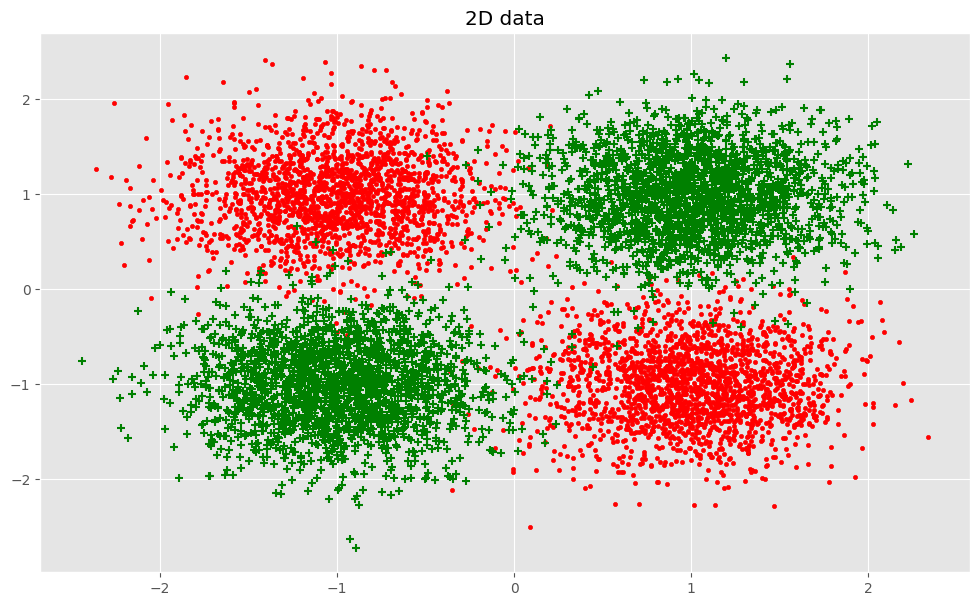

In [9]:
X_train, X_test, y_train, y_test  = dg.generate_2D_data(data_type=1, epsilon=0.3, train_size=0.8, nbex=10000)
dg.plot_2D_data(X_train, y_train)

In [10]:
# Create a sequential model
model = Sequential()

# Add modules to the sequential model
model.add_module(Linear(input_size=2, output_size=8))
model.add_module(TanH())
model.add_module(Linear(input_size=8, output_size=1))
model.add_module(Sigmoid())

loss_func = BCELoss()
optimizer = Optim(model,loss_func,1e-2)
batch_size = 100
epochs = 1000
losses = SGD(optimizer,X_train, y_train, batch_size,epochs,verbose=True)

Epoch 1/1000, Average Loss: 1.097216899860482
Epoch 101/1000, Average Loss: 0.07952997183707632
Epoch 201/1000, Average Loss: 0.06589954820878939
Epoch 301/1000, Average Loss: 0.061833249540263625
Epoch 401/1000, Average Loss: 0.05998796659340764
Epoch 501/1000, Average Loss: 0.05895487992267377
Epoch 601/1000, Average Loss: 0.058298243741405666
Epoch 701/1000, Average Loss: 0.05783648640057326
Epoch 801/1000, Average Loss: 0.0574985510650492
Epoch 901/1000, Average Loss: 0.05723317599973323
Training finished.


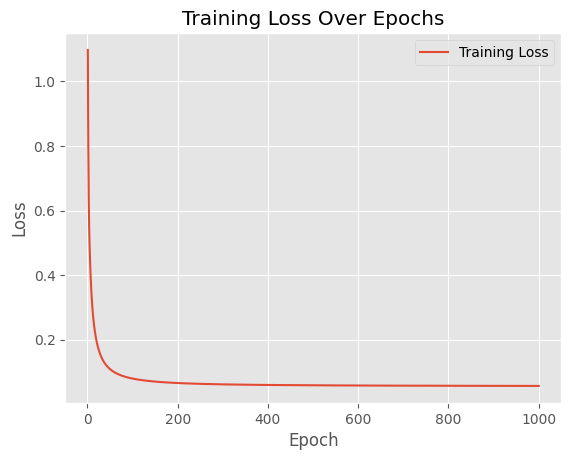

In [16]:
Display.plot_loss(losses)

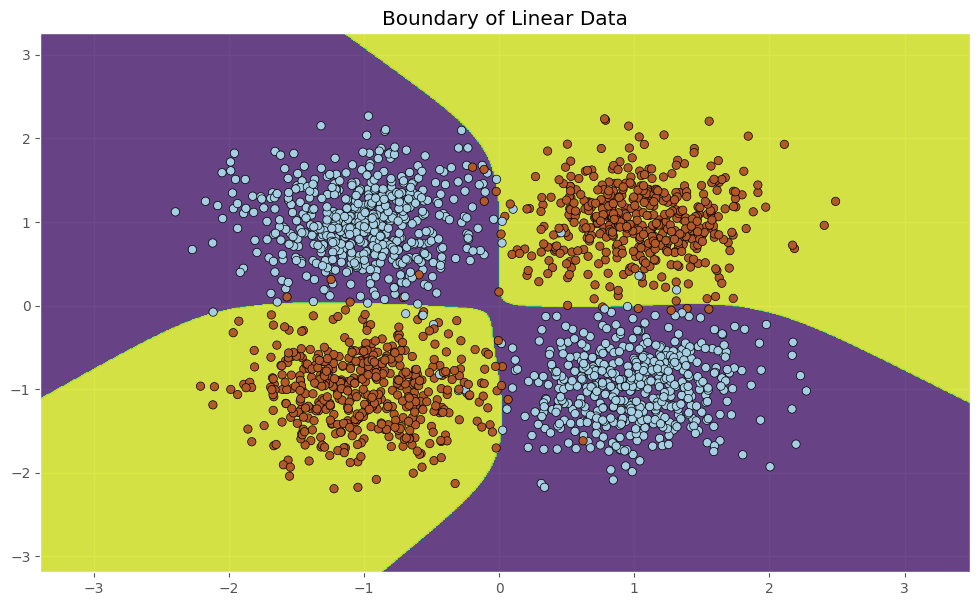

In [12]:
dg.plot_decision_boundary(X_test, y_test, model, "Boundary of Linear Data")
